In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Importing libraries

In [ ]:
import pandas as pd
import json
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textstat import flesch_reading_ease

## Loading the data

In [ ]:
# Define paths
machine_folder = "machines/*.jsonl"
human_file = "human.jsonl"

# Dictionary to store machine data
data_dict = {}

# Read all machine-generated JSONL files
for file_path in glob.glob(machine_folder):
    file_name = os.path.basename(file_path).replace(".jsonl", "")  # Extract file name
    records = []

    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            record = json.loads(line)
            record["id"] = record["id"].split("/", 1)[-1]  # Remove text before the first "/"
            records.append(record)

    # Convert to DataFrame and store in dictionary
    df = pd.DataFrame(records).set_index("id")
    data_dict[file_name] = df["text"]  # Store text column under the file name

# Combine all machine-generated data into a single DataFrame
machine_df = pd.concat(data_dict.values(), axis=1, keys=data_dict.keys())

# Read human.jsonl file
human_records = []
with open(human_file, "r", encoding="utf-8") as file:
    for line in file:
        record = json.loads(line)
        record["id"] = record["id"].split("/", 1)[-1]  # Remove text before the first "/"
        human_records.append(record)

# Convert human data to DataFrame
human_df = pd.DataFrame(human_records).set_index("id")

# Merge human and machine data
final_df = human_df.join(machine_df, how="outer")


In [ ]:
# Display the first few rows
print(final_df.head())
print(final_df.shape)
print(final_df.columns)

                                                                                                 text  \
id                                                                                                      
news-2021-01-01-2021-12-31-bideninauguration/ar...  Inaugural Address by President Joseph R. Biden...   
news-2021-01-01-2021-12-31-bideninauguration/ar...  Fact check: Biden inauguration impacted by pan...   
news-2021-01-01-2021-12-31-bideninauguration/ar...  Highlights from Joe Biden's 2021 inauguration\...   
news-2021-01-01-2021-12-31-bideninauguration/ar...  Biden takes the helm, appeals for unity to tak...   
news-2021-01-01-2021-12-31-bideninauguration/ar...  'The Hill We Climb': Read Amanda Gorman's inau...   

                                                                                   gpt-3.5-turbo-0125  \
id                                                                                                      
news-2021-01-01-2021-12-31-bideninauguration/ar...  Pr

In [ ]:
print(final_df.isnull().sum())  # Check missing values
print(final_df.duplicated().sum())  # Check duplicates

text                                    0
gpt-3.5-turbo-0125                      0
meta-llama-llama-2-70b-chat-hf          0
gpt-4-turbo-preview                     0
qwen-qwen1.5-72b-chat-8bit              0
chavinlo-alpaca-13b                     0
alpaca-7b                               0
mistralai-mistral-7b-instruct-v0.2      0
gemini-pro                              0
text-bison-002                          0
mistralai-mixtral-8x7b-instruct-v0.1    0
meta-llama-llama-2-7b-chat-hf           0
vicgalle-gpt2-open-instruct-v1          0
bigscience-bloomz-7b1                   0
dtype: int64
0


### Text length Analysis

Hypothesis :AI-generated text might have more uniform lengths compared to human-written text.

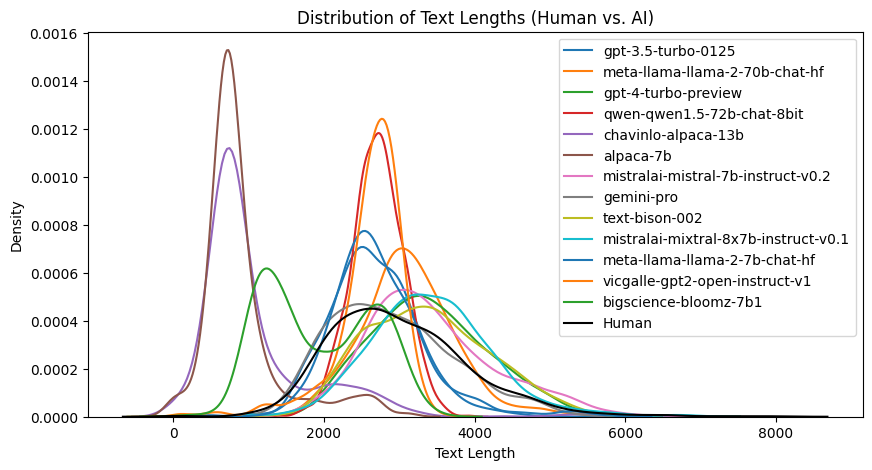

In [ ]:
final_df["human_text_length"] = final_df["text"].str.len()
for col in machine_df.columns:
    final_df[f"{col}_length"] = final_df[col].str.len()

plt.figure(figsize=(10, 5))
for col in machine_df.columns:
    sns.kdeplot(final_df[col + "_length"].dropna(), label=col)
sns.kdeplot(final_df["human_text_length"].dropna(), label="Human", color="black")
plt.xlabel("Text Length")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Text Lengths (Human vs. AI)")
plt.show()

<ipython-input-25-5f3985998b18>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis")


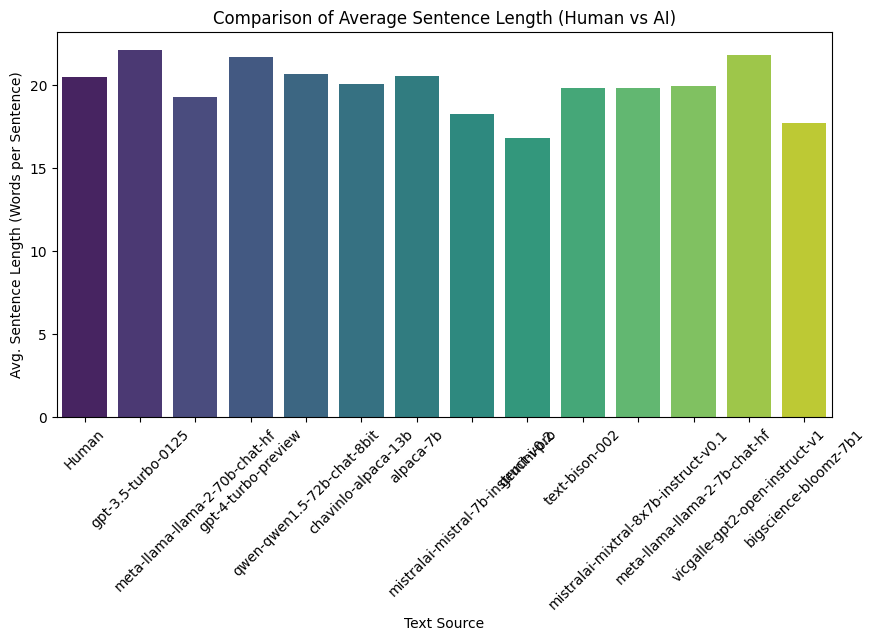

In [ ]:
def avg_sentence_length(texts):
    """Calculate average sentence length (words per sentence)."""
    return np.mean([len(str(text).split()) / (text.count(".") + 1) for text in texts.dropna()])

# Compute for human text
human_sentence_length = avg_sentence_length(final_df["text"])

# Compute for AI-generated text
ai_sentence_lengths = {col: avg_sentence_length(final_df[col]) for col in machine_df.columns}

# Prepare data for plotting
labels = ["Human"] + list(ai_sentence_lengths.keys())
values = [human_sentence_length] + list(ai_sentence_lengths.values())

# Create bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=values, palette="viridis")
plt.xlabel("Text Source")
plt.ylabel("Avg. Sentence Length (Words per Sentence)")
plt.title("Comparison of Average Sentence Length (Human vs AI)")
plt.xticks(rotation=45)
plt.show()

### Average word count analysis




Hypothesis : AI-generated text might have higher or more uniform word counts.

In [ ]:
final_df["human_word_count"] = final_df["text"].str.split().str.len()
for col in machine_df.columns:
    final_df[f"{col}_word_count"] = final_df[col].str.split().str.len()

final_df[["human_word_count"] + [col + "_word_count" for col in machine_df.columns]].describe()


human_word_count  gpt-3.5-turbo-0125_word_count  \
count       1087.000000                    1087.000000   
mean         494.102116                     402.776449   
std          155.266988                      90.547184   
min            5.000000                      11.000000   
25%          384.000000                     345.500000   
50%          475.000000                     396.000000   
75%          582.500000                     458.000000   
max         1343.000000                     932.000000   

       meta-llama-llama-2-70b-chat-hf_word_count  \
count                                1087.000000   
mean                                  495.600736   
std                                   107.150910   
min                                   187.000000   
25%                                   430.000000   
50%                                   489.000000   
75%                                   555.000000   
max                                   936.000000   

       gpt-4-turbo-preview_word_count  qwen-qwen1.5-72b-chat-8bit_word_count  \
count                     1087.000000                            1087.000000   
mean                       517.575897                             420.097516   
std                        122.998291                              51.634140   
min                        180.000000                             216.000000   
25%                        432.000000                             391.000000   
50%                        505.000000                             421.000000   
75%                        595.500000                             452.000000   
max                       1098.000000                             588.000000   

       chavinlo-alpaca-13b_word_count  alpaca-7b_word_count  \
count                     1087.000000           1087.000000   
mean                       163.496780            141.046918   
std                        115.079625             86.338228   
min                          0.000000              0.000000   
25%                        101.500000             98.000000   
50%                        125.000000            119.000000   
75%                        180.500000            152.000000   
max                        962.000000            548.000000   

       mistralai-mistral-7b-instruct-v0.2_word_count  gemini-pro_word_count  \
count                                    1087.000000            1087.000000   
mean                                      530.635695             451.327507   
std                                       135.814078             125.473363   
min                                       207.000000             189.000000   
25%                                       436.000000             354.500000   
50%                                       507.000000             438.000000   
75%                                       611.000000             530.000000   
max                                       947.000000             823.000000   

       text-bison-002_word_count  \
count                1087.000000   
mean                  512.924563   
std                   124.149852   
min                     0.000000   
25%                   418.500000   
50%                   506.000000   
75%                   597.500000   
max                   825.000000   

       mistralai-mixtral-8x7b-instruct-v0.1_word_count  \
count                                      1087.000000   
mean                                        528.152714   
std                                         124.869253   
min                                         125.000000   
25%                                         444.500000   
50%                                         520.000000   
75%                                         604.000000   
max                                        1064.000000   

       meta-llama-llama-2-7b-chat-hf_word_count  \
count                               1087.000000   
mean                                 429.876725   
std          

### Unique words count

In [ ]:
def unique_word_ratio(text):
    words = str(text).split()
    return len(set(words)) / len(words) if len(words) > 0 else 0

final_df["human_unique_ratio"] = final_df["text"].apply(unique_word_ratio)
for col in machine_df.columns:
    final_df[f"{col}_unique_ratio"] = final_df[col].apply(unique_word_ratio)

final_df[["human_unique_ratio"] + [col + "_unique_ratio" for col in machine_df.columns]].describe()


human_unique_ratio  gpt-3.5-turbo-0125_unique_ratio  \
count         1087.000000                      1087.000000   
mean             0.586846                         0.600991   
std              0.055874                         0.045189   
min              0.351005                         0.389968   
25%              0.557191                         0.572179   
50%              0.588486                         0.600000   
75%              0.621092                         0.629534   
max              1.000000                         1.000000   

       meta-llama-llama-2-70b-chat-hf_unique_ratio  \
count                                  1087.000000   
mean                                      0.513814   
std                                       0.062946   
min                                       0.255342   
25%                                       0.476413   
50%                                       0.517824   
75%                                       0.552829   
max                                       0.710801   

       gpt-4-turbo-preview_unique_ratio  \
count                       1087.000000   
mean                           0.599021   
std                            0.041780   
min                            0.468111   
25%                            0.568990   
50%                            0.597424   
75%                            0.626277   
max                            0.772222   

       qwen-qwen1.5-72b-chat-8bit_unique_ratio  \
count                              1087.000000   
mean                                  0.618302   
std                                   0.033268   
min                                   0.496198   
25%                                   0.596277   
50%                                   0.619159   
75%                                   0.641365   
max                                   0.749049   

       chavinlo-alpaca-13b_unique_ratio  alpaca-7b_unique_ratio  \
count                       1087.000000             1087.000000   
mean                           0.621448                0.646182   
std                            0.209306                0.199903   
min                            0.000000                0.000000   
25%                            0.550730                0.625403   
50%                            0.684685                0.704348   
75%                            0.750000                0.757576   
max                            1.000000                1.000000   

       mistralai-mistral-7b-instruct-v0.2_unique_ratio  \
count                                      1087.000000   
mean                                          0.545259   
std                                           0.069978   
min                                           0.210582   
25%                                           0.510001   
50%                                           0.555556   
75%                                           0.593842   
max                                           0.726962   

       gemini-pro_unique_ratio  text-bison-002_unique_ratio  \
count              1087.000000                  1087.000000   
mean                  0.565602                     0.563918   
std                   0.058222                     0.051968   
min                   0.356098                     0.000000   
25%                   0.529412                     0.535074   
50%                   0.567970                     0.566292   
75%                   0.604097                     0.595640   
max                   0.725100                     0.812500   

       mistralai-mixtral-8x7b-instruct-v0.1_unique_ratio  \
count                                        1087.000000   
mean                                            0.560337   
std                                             0.063123   
min                                             0.280075   
25%                                             0.525000   
50%                                             0.564544   
75%    

In [ ]:
nltk.download('stopwords')

# Load English stop words
stop_words = set(stopwords.words("english"))

def count_unique_words(text):
    if not isinstance(text, str):  # Handle missing values
        return 0
    words = text.lower().split()  # Convert to lowercase & split
    filtered_words = [word for word in words if word not in stop_words]  # Remove stop words
    return len(set(filtered_words))  # Count unique words

# Apply to human text
final_df["human_unique_words"] = final_df["text"].apply(count_unique_words)

# Apply to AI-generated text columns
for col in machine_df.columns:
    final_df[f"{col}_unique_words"] = final_df[col].apply(count_unique_words)

# Display summary statistics
print(final_df[["human_unique_words"] + [f"{col}_unique_words" for col in machine_df.columns]].describe())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


       human_unique_words  gpt-3.5-turbo-0125_unique_words  \
count         1087.000000                      1087.000000   
mean           223.957682                       192.805888   
std             64.913018                        39.672021   
min              4.000000                         8.000000   
25%            177.000000                       166.000000   
50%            217.000000                       190.000000   
75%            260.000000                       218.000000   
max            604.000000                       392.000000   

       meta-llama-llama-2-70b-chat-hf_unique_words  \
count                                  1087.000000   
mean                                    197.288868   
std                                      33.952292   
min                                     101.000000   
25%                                     174.000000   
50%                                     197.000000   
75%                                     220.000000   
max      

### Cosine Similarity to detect repetitiveness

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(final_df["text"].dropna().tolist() + final_df[machine_df.columns[0]].dropna().tolist())

cos_sim = cosine_similarity(tfidf_matrix)


Cosine Similarity Matrix Shape: (2174, 2174)


Human Intra-Group Similarity: 0.1473
AI Intra-Group Similarity: 0.1500


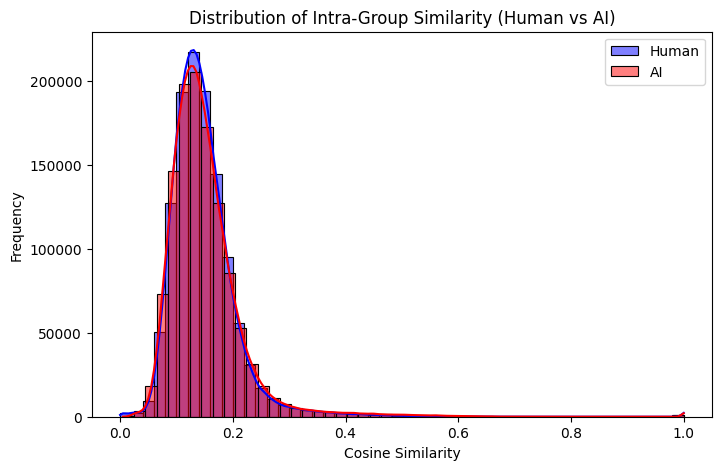

In [ ]:
# Separate human and AI text vectors
human_vectors = tfidf_matrix[:len(final_df["text"].dropna())]
ai_vectors = tfidf_matrix[len(final_df["text"].dropna()):]

# Compute intra-group similarity
human_sim = cosine_similarity(human_vectors)
ai_sim = cosine_similarity(ai_vectors)

# Get average similarity values (excluding self-similarity)
human_mean_sim = np.mean(human_sim[np.triu_indices_from(human_sim, k=1)])
ai_mean_sim = np.mean(ai_sim[np.triu_indices_from(ai_sim, k=1)])

print(f"Human Intra-Group Similarity: {human_mean_sim:.4f}")
print(f"AI Intra-Group Similarity: {ai_mean_sim:.4f}")


plt.figure(figsize=(8, 5))
sns.histplot(human_sim.flatten(), bins=50, color="blue", label="Human", kde=True)
sns.histplot(ai_sim.flatten(), bins=50, color="red", label="AI", kde=True)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Intra-Group Similarity (Human vs AI)")
plt.legend()
plt.show()


Human-to-AI Similarity: 0.1380


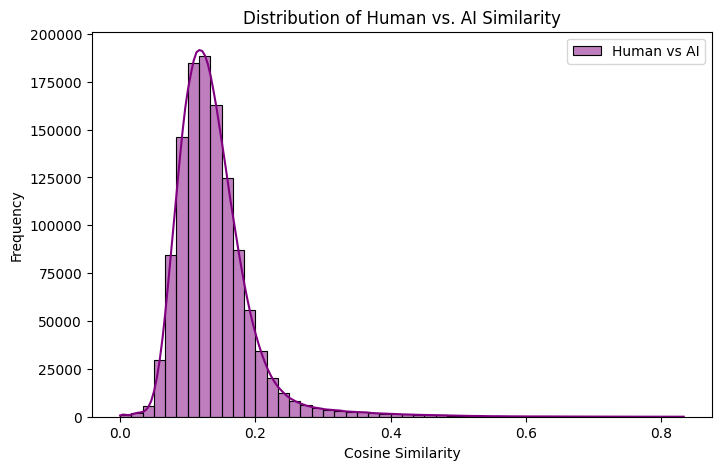

In [ ]:
# Compute inter-group similarity (Human vs AI)
human_ai_sim = cosine_similarity(human_vectors, ai_vectors)

# Get average similarity
human_ai_mean_sim = np.mean(human_ai_sim)

print(f"Human-to-AI Similarity: {human_ai_mean_sim:.4f}")

# Visualize distribution
plt.figure(figsize=(8, 5))
sns.histplot(human_ai_sim.flatten(), bins=50, color="purple", label="Human vs AI", kde=True)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Human vs. AI Similarity")
plt.legend()
plt.show()


### Readability analysis

In [ ]:
final_df["human_readability"] = final_df["text"].apply(lambda x: flesch_reading_ease(str(x)))
for col in machine_df.columns:
    final_df[f"{col}_readability"] = final_df[col].apply(lambda x: flesch_reading_ease(str(x)))

# Compare readability scores
print(final_df[["human_readability"] + [col + "_readability" for col in machine_df.columns]].describe())


       human_readability  gpt-3.5-turbo-0125_readability  \
count        1087.000000                     1087.000000   
mean           48.252649                       28.745465   
std            12.630345                       10.048796   
min           -97.870000                       -7.210000   
25%            41.415000                       22.240000   
50%            48.330000                       29.280000   
75%            55.830000                       35.680000   
max           117.160000                       57.500000   

       meta-llama-llama-2-70b-chat-hf_readability  \
count                                 1087.000000   
mean                                    40.501582   
std                                     10.855585   
min                                     -1.220000   
25%                                     33.240000   
50%                                     40.480000   
75%                                     47.655000   
max                                